# Your structured data into Tensorflow.

ML training often expects _flat_ data, like a line in a CSV.
[tf.Example](https://www.tensorflow.org/api_docs/python/tf/train/Example) was
designed to represent flat data. But the data you care about and want to predict
things about usually starts out _structured_.

Over and over again you have to write transform code that turns your structured data into Tensors. This repetitive transform code must be rewritten over and over for all your ML pipelines both for training _and_ serving! And it lets bugs slip into your ML pipeline. 

`struct2tensor` lets you take advantage of structured data _within_ your ML pipelines. It is:

* **for**: ML Engineers 
* **who**: train models on data that starts out structured
* **it is**: a python library 
* **that**: transforms your structured data into model-friendly (Sparse, Raggged, Dense, ...) tensors hermetically _within_ your model
* **unlike**: writing custom transforms over and over for training and serving.


---


![struct2tensor diagram showing the transform happens in the model](https://imgur.com/aqOX7nS.png)







# Demo example

Suppose we have this _structured_ data we want to train on. The source example data format is a [protobuff](https://developers.google.com/protocol-buffers). `struct2tensor` was built internally and works on protobuffers now. It can be extended to parquet, json, etc. in the future.

```
# e.g. a web session
message Session{
  message SessionInfo {
    string session_feature = 1;
    double session_duration_sec = 2;
  }
  SessionInfo session_info = 1;
  message Event {
    string query = 1;
    message Action {
      int number_of_views = 1;
    }
    repeated Action action = 2;
  }
  repeated Event event = 2;
}
```


In 3 steps we'll extract the fields we want with `struct2tensor`. We'll end up with batch-aligned `SparseTensors`:

1. Tell our model what examples we care about, e.g.  **`event`** (submessage `Session::Event`).
2. Pick the proto fields that we think are good features, say:
  * `session_info.session_feature`
  * `event.query`
3. Identify the label to predict, say  **`event.action.number_of_views`**  (the actual label could be sum(action.number_of_views for action in event))


Then we can build a struct2tensor query that:
* parses instances of this protocol buffer
* transforms the fields we care about
* creates the necessary `SparseTensor`s

Don't worry about some of these terms yet. We'll show you an example. And then explain the terms later.

## Install required packages (internal colab users: skip)

In [ ]:
#@test {"skip": true} 
# install struct2tensor
!pip install struct2tensor
# graphviz for pretty output
!pip install graphviz

## Some Pretty Printing and Imports

(not the "real" work yet)

In [ ]:
import base64
import numpy as np
import pprint
import os
import tensorflow
from graphviz import Source

import tensorflow as tf

from IPython.display import Image
from IPython.lib import pretty

import struct2tensor as s2t
from struct2tensor.test import test_pb2
from google.protobuf import text_format


def _display(graph):
  """Renders a graphviz digraph."""
  s = Source(graph)
  s.format='svg'
  return s
    

def _create_query_from_text_sessions(text_sessions):
  """Creates a struct2tensor query from a list of pbtxt of struct2tensor.test.Session."""
  sessions = tf.constant([
      text_format.Merge(
          text_session, 
          test_pb2.Session()
      ).SerializeToString()
      for text_session in text_sessions
  ])
  return s2t.create_expression_from_proto(
    sessions, test_pb2.Session.DESCRIPTOR)

def _prensor_pretty_printer(prensor, p, cycle):
  """Pretty printing function for struct2tensor.prensor.Prensor"""
  pretty.pprint(prensor.get_sparse_tensors())

def _sp_pretty_printer(sp, p, cycle):
  """Pretty printing function for SparseTensor."""

  del cycle
  p.begin_group(4, "SparseTensor(")
  p.text("values={}, ".format(sp.values.numpy().tolist()))
  p.text("dense_shape={}, ".format(sp.dense_shape.numpy().tolist()))
  p.break_()
  p.text("indices={}".format(sp.indices.numpy().tolist()))
  p.end_group(4, ")")


pretty.for_type(tf.SparseTensor, _sp_pretty_printer)
pretty.for_type(s2t.Prensor, _prensor_pretty_printer)

_pretty_print = pretty.pprint

print("type-specific pretty printing ready to go")

type-specific pretty printing ready to go


## The real work:

A function that parses our structured data (protobuffers) into tensors:

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None), dtype=tf.string)], autograph=False)
def parse_session(serialized_sessions):
  """A TF function parsing a batch of serialized Session protos into tensors.

  It is a TF graph that takes one 1-D tensor as input, and outputs a
  Dict[str, tf.SparseTensor]
  """
  query = s2t.create_expression_from_proto(
      serialized_sessions, test_pb2.Session.DESCRIPTOR)
  # Move all the fields of our interest to under "event".  
  query = query.promote_and_broadcast({
          "session_feature": "session_info.session_feature",
          "action_number_of_views": "event.action.number_of_views" },
          "event")
  # Specify "event" to be examples.
  query = query.reroot("event")
  # Extract all the fields of our interest.
  projection = query.project(["session_feature", "query", "action_number_of_views"]) 
  prensors = s2t.calculate_prensors([projection])
    
  output_sparse_tensors = {}
  for prensor in prensors:
    path_to_tensor = prensor.get_sparse_tensors()
    output_sparse_tensors.update({str(k): v for k, v in path_to_tensor.items()})
  
  return output_sparse_tensors

print("Defined the workhorse func: (structured data at rest) -> (tensors)")

Defined the workhorse func: (structured data at rest) -> (tensors)


## Lets see it in action:

In [ ]:
serialized_sessions = tf.constant([
    text_format.Merge(
        """
        session_info {
          session_duration_sec: 1.0
          session_feature: "foo"
        }
        event {
          query: "Hello"
          action {
            number_of_views: 1
          }
          action {
          }
        }
        event {
          query: "world"
          action {
            number_of_views: 2
          }
          action {
            number_of_views: 3
          }
        }
        """,
        test_pb2.Session()
    ).SerializeToString()
])

_pretty_print(parse_session(serialized_sessions))

{'action_number_of_views': SparseTensor(values=[1, 2, 3], dense_shape=[2, 2], 
     indices=[[0, 0], [1, 0], [1, 1]]),
 'query': SparseTensor(values=[b'Hello', b'world'], dense_shape=[2], 
     indices=[[0], [1]]),
 'session_feature': SparseTensor(values=[b'foo', b'foo'], dense_shape=[2, 1], 
     indices=[[0, 0], [1, 0]])}


See how we went from our pre-pipeline data (the Protobuffer) all the way to the structured data, packed into `SparseTensor`s?

# Digging Far Deeper
Interested and want to learn more? Read on...

Let's define several terms we mentioned before:

### Prensor

A Prensor (protobuffer + tensor) is a data structure storing the data we work on. We use protobuffers a lot at Google. `struct2tensor` can support other structured formats, too.

For example, throughout this colab we will be using proto
[`struct2tensor.test.Session`](http://cs/symbol:struct2tensor.test.Session). A schematic visualization
of a selected part of the prensor from that proto looks like:

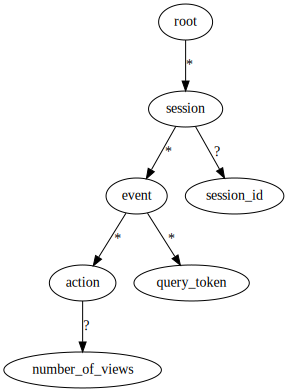

In [ ]:
#@title { display-mode: "form" }
#@test {"skip": true} 

_display("""
digraph {
  root -> session [label="*"];
  session -> event [label="*"];
  session -> session_id [label="?"];
  event -> action [label="*"];
  event -> query_token [label="*"]
  action -> number_of_views [label="?"];
}
""")


We will be using visualizations like this to demostrate struct2tensor queries later.

Note:

* The "*" on the edge means the pointed node has repeated values; while the "?" means it has an optional value.
* There is always a "root" node whose only child is the root of the structure. Note that it's "repeated" because one struct2tensorTree can represent multiple instances of a structure.




### struct2tensor Query
A struct2tensor query transforms a Prensor into another Prensor.

For example, `broadcast` is a query that replicates a node as a child of one of its siblings.

Applying
```
broadcast(
    source_path="session.session_id",
    sibling="event",
    new_field_name="session_session_id")
```

on the previous tree gives:



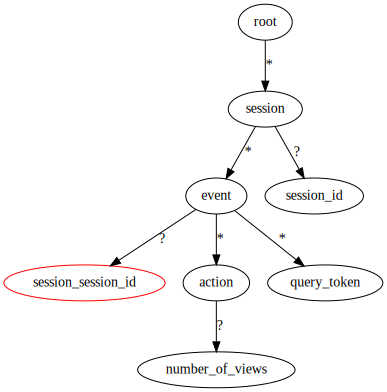

In [ ]:
#@title { display-mode: "form" }
#@test {"skip": true} 

_display("""
digraph {
  session_session_id [color="red"];
  root -> session [label="*"];
  session -> event [label="*"];
  session -> session_id [label="?"];
  event -> action [label="*"];
  event -> session_session_id [label="?"];
  event -> query_token [label="*"];
  action -> number_of_views [label="?"];
}
""")


We will talk about common struct2tensor queries in later sections.

### Projection
A projection of paths in a Prensor produces another Prensor with just the selected paths.

#### Logical representation of a projection
The structure of the projected path can be represented losslessly as nested lists. For example, the projection of `event.action.number_of_views` from the struct2tensorTree formed by the following two instances of `struct2tensor.test.Session`:
```
{
  event { action { number_of_views: 1} action { number_of_views: 2} action {} }
  event {}
}, {
  event { action { number_of_views: 3} }
}
```

is:

```
[  # the outer list has two elements b/c there are two Session protos.
 [  # the first proto has two events
   [[1],[2],[]],  # 3 actions, the last one does not have a number_of_views.
   [], # the second event does not have action
 ],
 [ # the second proto has one event
   [[3]],
 ],
]
```

#### Representing nested lists with `tf.SparseTensor`

struct2tensor uses `tf.SparseTensor` to represent the above nested list in the projection results. Note that `tf.SparseTensor` essentially enforces that the lists nested at the same level to have the same length (because the there is a certain size for each dimension), therefore this representation is lossy. The above nested lists, when written as a SparseTensor will look like:
```
tf.SparseTensor(
  dense_shape=[2, 2, 3, 1],  # each is the maximum length of lists at the same nesting level.
  values = [1, 2, 3],
  indices = [[0, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0]]
)
```

Note that the last dimension is useless: the index of that dimension will always be 0 for any present value because number_of_views is an optional field. So struct2tensors library will actually "squeeze" all the optional dimensions.

The actual result would be:

In [ ]:
query = _create_query_from_text_sessions(['''
  event { action { number_of_views: 1} action { number_of_views: 2} action {} }
  event {}
  ''', '''
  event { action { number_of_views: 3} }
  ''']
  ).project(["event.action.number_of_views"])

prensor = s2t.calculate_prensors([query])
pretty.pprint(prensor)

[{event.action.number_of_views: SparseTensor(values=[1, 2, 3], dense_shape=[2, 2, 3], 
     indices=[[0, 0, 0], [0, 0, 1], [1, 0, 0]])}
]


struct2tensor's internal data model is closer to the above "nested lists" abstraction and sometimes it's easier to reason with "nested lists" than with `SparseTensor`s.

Recently, [`tf.RaggedTensor`](https://www.tensorflow.org/guide/ragged_tensors) was introduced to represent nested lists exactly. We are working on adding support for projecting into ragged tensors.

## Common struct2tensor Queries

### `promote`

Promotes a node to become a sibling of its parent. If the node is repeated, then all its values are concatenated (the order is preserved).

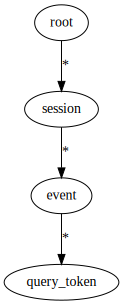

In [ ]:
#@title { display-mode: "form" }
#@test {"skip": true} 

_display('''
digraph {
  root -> session [label="*"];
  session -> event [label="*"];
  event -> query_token [label="*"];
}
''')

`promote(source_path="event.query_token", new_field_name="event_query_token")`

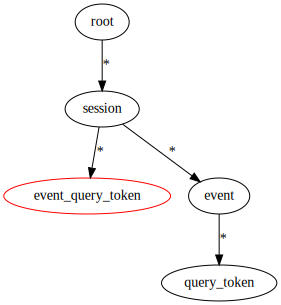

In [ ]:
#@title { display-mode: "form" }
#@test {"skip": true} 

_display('''
digraph {
  event_query_token [color="red"];
  root -> session [label="*"];
  session -> event [label="*"];
  session -> event_query_token [label="*"];
  event -> query_token [label="*"];
}
''')

In [ ]:
query = (_create_query_from_text_sessions([
"""
event {
  query_token: "abc"
  query_token: "def"
}
event {
  query_token: "ghi"
}
"""])
        .promote(source_path="event.query_token", new_field_name="event_query_token")
        .project(["event_query_token"]))

prensor = s2t.calculate_prensors([query])

_pretty_print(prensor)

[{event_query_token: SparseTensor(values=[b'abc', b'def', b'ghi'], dense_shape=[1, 3], 
     indices=[[0, 0], [0, 1], [0, 2]])}
]


The projected structure is like:
```
{
  # this is under Session.
  event_query_token: "abc"
  event_query_token: "def"
  event_query_token: "ghi"
}
```

### `broadcast`

Broadcasts the value of a node to one of its sibling. The value will be replicated if the sibling is repeated. This is similar to TensorFlow and Numpy's [broadcasting semantics](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html).


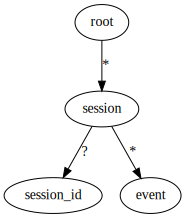

In [ ]:
#@title { display-mode: "form" }
#@test {"skip": true} 

_display('''
digraph {
  root -> session [label="*"];
  session -> session_id [label="?"];
  session -> event [label="*"];
}
''')

`broadcast(source_path="session_id", sibling_field="event", new_field_name="session_session_id")`

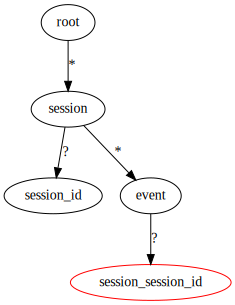

In [ ]:
#@title { display-mode: "form" }
#@test {"skip": true} 

_display('''
digraph {
  session_session_id [color="red"];
  root -> session [label="*"];
  session -> session_id [label="?"];
  session -> event [label="*"];
  event -> session_session_id [label="?"];
}
''')

In [ ]:
query = (_create_query_from_text_sessions([
"""
session_id: 8
event { }
event { }
"""])
        .broadcast(source_path="session_id",
                   sibling_field="event",
                   new_field_name="session_session_id")
        .project(["event.session_session_id"]))

prensor = s2t.calculate_prensors([query])
_pretty_print(prensor)

[{event.session_session_id: SparseTensor(values=[8, 8], dense_shape=[1, 2], 
     indices=[[0, 0], [0, 1]])}
]


The projected structure is like:
```
{
  event {
    session_session_id: 8
  }
  event {
    session_session_id: 8
  }
}
```

### `promote_and_broadcast`
The query accepts multiple source fields and a destination field. For each source field, it first promotes it to the least common ancestor with the destination field (if necessary), then broadcasts it to the destination field (if necessary).

Usually for the purpose of machine learning, this gives a reasonable flattened representation of nested structures.

```
promote_and_broadcast(
    path_dictionary={
        'session_info_duration_sec': 'session_info.session_duration_sec'},
    dest_path_parent='event.action')
```
is equivalent to:
```
promote(source_path='session_info.session_duration_sec',
    new_field_name='anonymous_field1')

broadcast(source_path='anonymous_field1',
    sibling_field='event.action',
    new_field_name='session_info_duration_sec')
```


### `map_field_values`

Creates a new node that is a sibling of a leaf node. The values of the new node are results of applying the given function to the values of the source node.

Note that the function provided takes 1-D tensor that contains all the values of the source node as input and should also output a 1-D tensor of the same size, and it should build TF ops.


In [ ]:
query = (_create_query_from_text_sessions([
"""
session_id: 8
""",
"""
session_id: 9
"""])
        .map_field_values("session_id", lambda x: tf.add(x, 1), dtype=tf.int64,
                          new_field_name="session_id_plus_one")
        .project(["session_id_plus_one"]))
    
prensor = s2t.calculate_prensors([query])

_pretty_print(prensor)

[{session_id_plus_one: SparseTensor(values=[9, 10], dense_shape=[2], 
     indices=[[0], [1]])}
]


### `reroot`

Makes the given node the new root of the struct2tensorTree. This has two effects:

* restricts the scope of the struct2tensorTree
  + The field paths in all the following queries are relative to the new root
  + There's no way to refer to nodes that are outside the subtree rooted at the new root.
* changes the batch dimension.


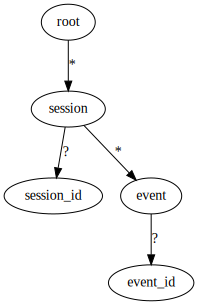

In [ ]:
#@title { display-mode: "form" }
#@test {"skip": true} 

_display('''
digraph {
  root -> session [label="*"];
  session -> session_id [label="?"];
  session -> event [label="*"];
  event -> event_id [label="?"];
}
''')

`reroot("event")`

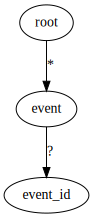

In [ ]:
#@title { display-mode: "form" }
#@test {"skip": true} 

_display('''
digraph {
  root -> event [label="*"];
  event -> event_id [label="?"];
}
''')

In [ ]:
#@title { display-mode: "form" }
text_protos = ["""
session_id: 1
event {
  event_id: "a"
}
event {
  event_id: "b"
}
""",
"""
session_id: 2
""",
"""
session_id: 3
event {
  event_id: "c"
}
"""
]
print("""Assume the following Sessions: """)
print([text_format.Merge(p, s2t.test.test_pb2.Session()) for p in text_protos])
print("\n")
reroot_example_query = _create_query_from_text_sessions(text_protos)

print("""project(["event.event_id"]) before reroot() (the batch dimension is the index to sessions):""")
_pretty_print(s2t.calculate_prensors([reroot_example_query.project(["event.event_id"])]))
print("\n")
print("""project(["event_id"]) after reroot() (the batch dimension becomes the index to events):""")
_pretty_print(s2t.calculate_prensors([reroot_example_query.reroot("event").project(["event_id"])]))

Assume the following Sessions: 
[session_id: 1
event {
  event_id: "a"
}
event {
  event_id: "b"
}
, session_id: 2
, session_id: 3
event {
  event_id: "c"
}
]


project(["event.event_id"]) before reroot() (the batch dimension is the index to sessions):
[{event.event_id: SparseTensor(values=[b'a', b'b', b'c'], dense_shape=[3, 2], 
     indices=[[0, 0], [0, 1], [2, 0]])}
]


project(["event_id"]) after reroot() (the batch dimension becomes the index to events):
[{event_id: SparseTensor(values=[b'a', b'b', b'c'], dense_shape=[3], 
     indices=[[0], [1], [2]])}
]


## Apache Parquet Support

`struct2tensor` offers an [Apache Parquet](https://parquet.apache.org/) [tf.DataSet](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) that allows reading from a Parquet file and apply queries to manipulate the structure of the data.

Because of the powerful struct2tensor library, the dataset will only read the Parquet columns that are required. This reduces I/O cost if we only need a select few columns.

### Preparation

Please run the code cell at [Some Pretty Printing and Imports](#scrollTo=dIxHSM3VQfUu&line=1&uniqifier=1) to ensure that all required modules are imported, and that pretty print works properly.


#### Prepare the input data

In [ ]:
# Download our sample data file from the struct2tensor repository. The desciption of the data is below.
#@test {"skip": true} 

!curl -o dremel_example.parquet 'https://raw.githubusercontent.com/google/struct2tensor/master/struct2tensor/testdata/parquet_testdata/dremel_example.parquet'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1657  100  1657    0     0   8122      0 --:--:-- --:--:-- --:--:--  8122


### Example

We will use a sample Parquet data file (*dremel_example.parquet*), which contains data based on the example used in this paper: https://storage.googleapis.com/pub-tools-public-publication-data/pdf/36632.pdf 

The file *dremel_example.parquet* has the following schema:

```
message Document {
  required int64 DocId;
  optional group Links {
    repeated int64 Backward;
    repeated int64 Forward; }
  repeated group Name {
    repeated group Language {
      required string Code;
      optional string Country; }
    optional string Url; }}
 ```

and contains the following data:
  

```
Document
  DocId: 10
  Links
    Forward: 20
    Forward: 40
    Forward: 60
  Name
    Language
      Code: 'en-us'
      Country: 'us'
    Language
      Code: 'en'
    Url: 'http://A'
  Name
    Url: 'http://B'
  Name
    Language
      Code: 'en-gb'
      Country: 'gb'
Document
  DocId: 20
  Links
    Backward: 10
    Backward: 30
    Forward: 80
  Name
    Url: 'http://C'
```


In this example, we will promote and broadcast the field `Links.Forward` and project it.

batch_size will be the number of records (`Document`) per prensor. This works with optional and repeated fields, and will be able to batch the entire record.

Feel free to try `batch_size = 2` in the below code. (Note this parquet file only has 2 records (`Document`) total).


In [ ]:
#@test {"skip": true} 

from struct2tensor import expression_impl

filenames = ["dremel_example.parquet"]
batch_size = 1

exp = s2t.expression_impl.parquet.create_expression_from_parquet_file(filenames)
new_exp = exp.promote_and_broadcast({"new_field": "Links.Forward"}, "Name")
proj_exp = new_exp.project(["Name.new_field"])
proj_exp_needed = exp.project(["Name.Url"]) 
# Please note that currently, proj_exp_needed needs to be passed into calculate.
# This is due to the way data is stored in parquet (values and repetition & 
# definition levels). To construct the node for "Name", we need to read the 
# values of a column containing "Name".
pqds = s2t.expression_impl.parquet.calculate_parquet_values([proj_exp, proj_exp_needed], exp, 
                                        filenames, batch_size)

for prensors in pqds:
  new_field_prensor = prensors[0]
  print("============================")
  print("Schema of new_field prensor: ")
  print(new_field_prensor)
  print("\nSparse tensor representation: ")
  pretty.pprint(new_field_prensor)
print("============================")

/usr/local/lib/python3.6/dist-packages/struct2tensor/expression_impl/parquet.py:65: FutureWarning: The 'field_by_name' method is deprecated, use 'field' instead
  [arrow_schema.field_by_name(name) for name in arrow_schema.names]))
/usr/local/lib/python3.6/dist-packages/struct2tensor/expression_impl/parquet.py:396: FutureWarning: The 'field_by_name' method is deprecated, use 'field' instead
  for step in curr_steps_as_set


Schema of new_field prensor: 
RootNodeTensor root
  repeated ChildNodeTensor Name
    repeated <dtype: 'int64'> new_field

Sparse tensor representation: 
{Name.new_field: SparseTensor(values=[20, 40, 60, 20, 40, 60, 20, 40, 60], dense_shape=[1, 3, 3], 
     indices=[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 0], [0, 1, 1], [0, 1, 2], [0, 2, 0], [0, 2, 1], [0, 2, 2]])}

Schema of new_field prensor: 
RootNodeTensor root
  repeated ChildNodeTensor Name
    repeated <dtype: 'int64'> new_field

Sparse tensor representation: 
{Name.new_field: SparseTensor(values=[80], dense_shape=[1, 1, 1], 
     indices=[[0, 0, 0]])}

